#Wikidpedia Page Views and Signal Processing of Time Series
## by Daniel for the Meetup group, _Scientists New to Data Science_


&nbsp;

<img src="http://www.poroussilicon.com/uploads/2/9/7/0/29708759/s409297289500125799_p5_i7_w378.png">
<img src="tarceva_plot.png">

This notebook uses Wikipedia page views as a souce of time series data. The reason I'm so interested in WP, is that it may be a proxy for other other media channel interest. 

For instance, what has been the national interest on the cancer treatment drug Tarceva. It's difficult to get a long history consumer of content from Twitter, Youtube, Facebook, etc. Wikipedia offers a full seven years of basic usage stats. 

I have three goals with this notebook:

* Show how to pull view data from Wikipedia
* Provide examples of signal processing of time series 
* Understand the behavior of Wikipedia users (content viewers)

In addition, the contributor's stats on edits is available. That also might yield some interesting analysis. For instance the page maintainers for a drug, might well be a key influencer in the field. Or, the time series data
which belongs to an editor, might be used as a co-variate to be removed. Perhaps the amount of time a competitor company puts into their WP article will provide insight for a client.

#### For now, let's restrict ourselves to page views.

**CONTENTS**

* <a href='#core logic'>Core Logic To Download View Stats</a>
* <a href='#tarceva stats'>Tarveca Stats</a>
 * <a href='#tarceva time series monthly'>Monthly Time Series</a>
 * <a href='#tarceva covariates'>Gathering Covariates</a>
 * <a href='#correlation'>Correlation</a>
 * <a href='#GLM'>GLM</a>
 * <a href='#fft'>FFT</a>
* <a href='#filtering'>Convolution Filter</a>
* <a href='#peaks'>Identifying Peaks</a>
* <a href='#threshold peaks'>Thresholding Peaks</a>
* <a href='#random'>Random Sample</a>
 * <a href='#ave random'>Averaging</a>
 * <a href='#interpolate'>Interpolate</a>
 * <a href='#weighted average'>Weighted Average</a>
* <a href='#api'>API: Category Sampling</a>
* <a href='#detrended_tarceva'>Detrending Using the Average of the Random Time Series</a>

## Version Information

# https://github.com/rasbt/watermark
%load_ext watermark
%watermark -g -p numpy,scipy,pandas,matplotlib,statsmodels

## Core Logic For Downloading the Data
<a id='core logic'></a>

In [1]:
%matplotlib inline
# this sets up the default fig size
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 5)
import urllib2
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import json
from time import sleep

class WikiViews(object):
    def __init__(self, url, start_date, end_date):
        self.url = url
        self.url_base = "http://stats.grok.se/json/en/%(date)s/%(url)s" 
        self.date_range = pd.date_range(start=start_date, end=end_date, freq='m')
        self.try_max = 3
        self.show_url_fails = False
        
    def _get_data(self, url, try_num):
        if try_num > self.try_max:
            print "reached max try's"
            return None
        try:
            response = urllib2.urlopen(url)
            out = response.read()
            return out
        except urllib2.HTTPError:
            sleep(5)
            try_num += 1
            if self.show_url_fails:
                print "try again:%i:%s" %(try_num, url)
            self._get_data(url, try_num)
        
    def loop_over_dates(self):
        DF = pd.DataFrame()
        
        for date in self.date_range:
            date_string = date.strftime("%Y%m")
            url = self.url_base %{'date':date_string,
                                  'url':self.url
                                  }
            try:
                try_num = 0
                out = self._get_data(url, try_num) 
                if out is None:
                    continue

            except Exception, err: # modicum of trouble shooting
                print err          # mystery failures
                continue
                #raise Exception
                
            out = json.loads(out) # first column happens to be a date string, which will become the index
            df = pd.DataFrame(out) 
            
            DF = DF.append(df)
            DF = DF.reindex(fill_value=0) # make sure that all days are filled for later comparison
        
        DF['date'] = DF.index # useful when loading the data from csv file
        return DF
    
    @classmethod # shouldn't need class instance for this but it nice to keep organized in one place
    def plot_time_series(self, df, norm=False):
        '''Plot time series average per month and print labels '''
        grp = df.groupby('month')
        y = grp.sum()
        
        if 'daily_views' in y.keys(): # case when df is a single output of loop_over_dates
            y = y['daily_views']
        else:                         # case for df concatenation
            pass
        
        if norm:
            y /= np.std(y)
        
        plt.plot(y)      
        plt.grid(True)
        plt.title("Daily Views Summed Over Months", fontsize=15)
        plt.ylabel("Views per month", fontsize=15)
        plt.xlabel("Date", fontsize=15)
        plt.xlim(0, y.shape[0])
        
        interval = 2
        labels = df.month.unique()
        labels = labels[0::interval]
        
        n = np.arange(len(y))[0::interval]
        plt.xticks(n, labels, rotation='vertical')      
    
    @classmethod                
    def fft(self, data):
        '''Plot FFT using Welch's method, daily resolution '''
        #plt.figure(figsize=(13, 7))
        f, y = scipy.signal.welch(data, fs=1.0, nperseg=256, noverlap=128, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        
        plt.grid(True) # not working likely b/c of conflict with seaborn artist
        plt.title("Welch FFT: Wiki Views")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs



## Getting the Tarceva Stats
<a id='tarceva stats'></a>

This will take a while. You may wish to change the _start_ and _end_ dates in the next cell to move through faster.
Later in the notebook I save all the pulls to csv which causes some annoyance in the form of extra code. You may wish to selectively run each cell rather than _run all_.

It's important to note, that Tarceva is the trade name for _Erlotinib Hydrochloride_.
The Wikipedia page view stats do not always use the original article name. This is true in the case of the
Tarceva page, where the page view stats use the _Erlotinib_ name in the URL. This occurs again with _Iressa_, which is described below.

In [ ]:
# setup constants for dates of the query 
start = '1/1/2008'
end = '10/1/2015'

In [280]:
wv = WikiViews("Erlotinib", start, end )
tar = wv.loop_over_dates()

reached max try's
reached max try's
reached max try's
reached max try's
reached max try's
reached max try's
reached max try's
reached max try's
reached max try's
reached max try's


In [281]:
tar.head()

,daily_views,month,project,rank,title,date
2008-04-01,167,200804,en,-1,Erlotinib,2008-04-01
2008-04-02,192,200804,en,-1,Erlotinib,2008-04-02
2008-04-03,188,200804,en,-1,Erlotinib,2008-04-03
2008-04-04,163,200804,en,-1,Erlotinib,2008-04-04
2008-04-05,95,200804,en,-1,Erlotinib,2008-04-05


## Time Series
The data is returned on a daily basis. I don't think that is very useful for a first look. Most people want to see the trend. We should keep in mind, that WP's user's have grown over the years and that may account for some trending. We'll use signal processing techniques later that will account for that.
<a id='tarceva time series monthly'></a>

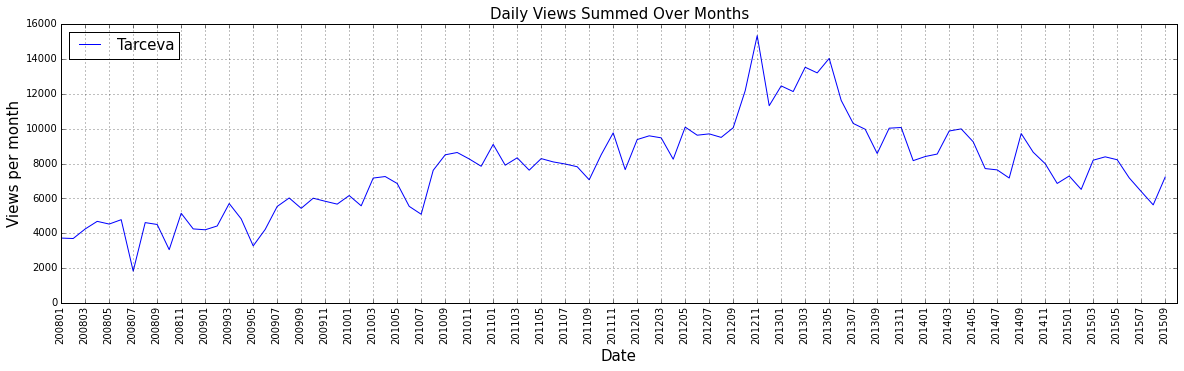

In [6]:
WikiViews.plot_time_series(tar)
plt.legend((["Tarceva"]), loc="upper left", fontsize=15)  

## Covariates
<a id='tarceva covariates'></a>

We'd like to be able to know what high level topics influence the interest in the drug Tarceva.
We'll look for covariates and try to come up with some entry point ideas that we would present to a domain
export or analyst.

We would want to talk to a domain expert about that. Of course we an do some Google searches of our own and try to find covariates. 

Google search about Tarceva turns up:

* Tarvcea acts on, "Epidermal growth factor receptor" 
* Tarceva is also used to treat
 * Non small cell lung cancer
 * Pancreatic cancer
* Older drug named Iressa is the predecessor

Might as well do some more Wikipedia pulls, because it will be hard to find source to cross reference in the news that covers a span of time. Let's try more topics.

In [34]:
wv = WikiViews("Epidermal_growth_factor_receptor", start, end )
egfr = wv.loop_over_dates()

In [35]:
wv = WikiViews("Lung_cancer", start, end)
lung = wv.loop_over_dates()

In [36]:
wv = WikiViews("Gefitinib", start, end)
iressa = wv.loop_over_dates()

In [37]:
tar['date'] = df.index
df = pd.concat({'date':tar.date,
                'month':tar.month, 
                'tar':tar.daily_views, 
                'egfr':egfr.daily_views,
                'lung':lung.daily_views,
                'iressa':iressa.daily_views
               }, axis=1)

df.to_csv("/home/daniel/git/Python2.7/DataScience/notebooks/wikipedia_views/wiki_views_data.csv", index=False)

In [39]:
df.head()
dfcopy = df.copy()

I kept coming back to this notebook for work on it and didn't want to wait for the data to download.
Below I'm loading it back from a csv file.

In [2]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/notebooks/wikipedia_views/wiki_views_data.csv")
df.set_index("date", drop=True, inplace=True)
df.head()

,egfr,iressa,lung,month,tar
date,,,,,
2008-01-01,64,40,1357,200801,47
2008-01-02,156,81,2205,200801,133
2008-01-03,213,100,2728,200801,118
2008-01-04,174,89,2582,200801,108
2008-01-05,87,53,1885,200801,72


Examine for correlation by eye. We need to normalize to correct for scale. Note, the y label units will not be 
applicable for this plot.

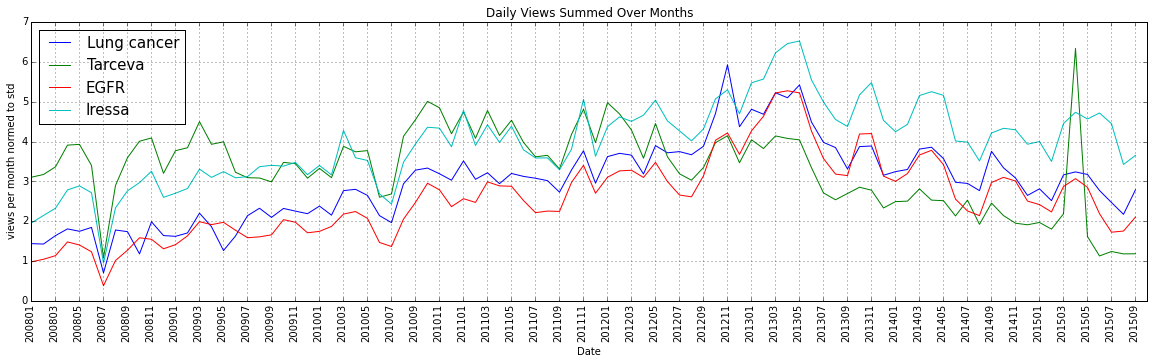

In [291]:
WikiViews.plot_time_series(df[['tar', 'lung', 'egfr', 'iressa', 'month']], norm=True)
plt.legend(('Lung cancer', 'Tarceva', 'EGFR', 'Iressa'), loc="upper left", fontsize=15)
plt.ylabel("views per month normed to std")

## Correlation
<a id='correlation'></a>

Recall, this is just a very basic exercise. We are using really obviously connected information to form a quick and dirty report suitable for an analysis to look at on day one of a project. We will need to search more for data which could be used to predict.

Examination by eye of the above plots, looks like all 4 topics are roughly correlated in time.
It's good to get a quantifier though. Tarceva and Lung Cancer have a relatively small correlation compared to EGFR.




In [292]:
df[['tar', 'egfr', 'lung', 'iressa']].corr()

,tar,egfr,lung,iressa
tar,1.000000,0.821299,0.210851,0.774580
egfr,0.821299,1.000000,0.227172,0.872449
lung,0.210851,0.227172,1.000000,0.235276
iressa,0.774580,0.872449,0.235276,1.000000


## GLM with statsmodels
<a id='GLM'><a/>

In [293]:
import statsmodels.api as sm
signal = df['tar']
cov = df[['egfr','iressa','lung']]
cov = np.asarray(cov.astype(np.float32))

signal = np.asarray(df['tar'].astype(np.float32))

# GLM
model = sm.GLM(signal, cov, family=sm.families.Gaussian())   
res = model.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2860
Model:                            GLM   Df Residuals:                     2857
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                   5785.60152446
Method:                          IRLS   Log-Likelihood:                -16445.
Date:                Sat, 10 Oct 2015   Deviance:                   1.6529e+07
Time:                        22:37:47   Pearson chi2:                 1.65e+07
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3221      0.011     28.216      0.000         0.300     0.344
x2             0.4569      0.032     14.358      0.0

# Moving on with numerical analysis technics
##  Filtering and FFT
<a id='fft'></a>

Now we'd like to see some frequency anaylsis. The FFT won't tell us what day(s) the cycles repeat on,
but it will show if any periodicity exists. 

Below is the time series by day, rather than by monthly sum as it was above.

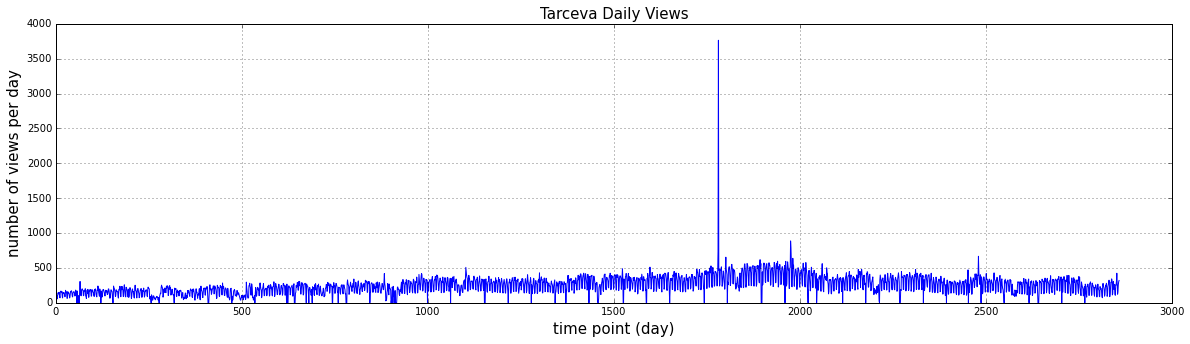

In [295]:
tar = df.tar
plt.plot(tar)
plt.grid(True)
plt.title("Tarceva Daily Views", fontsize=15)
plt.ylabel("number of views per day", fontsize=15)
plt.xlabel("time point (day)", fontsize=15)

Now the frequency analysis. Note that in the Welch's function which produces this plot, the detending feature is set to _linear_.

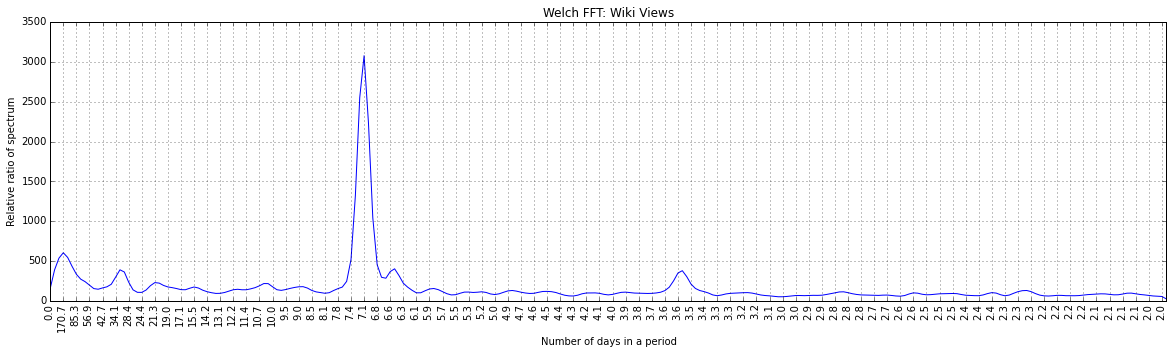

In [296]:
f, y, frq = WikiViews.fft(tar)

There's a clear weekly frequency that I've seen in other social media channels. People may look use Wikipedia on the weekends more so than weekdays. The longer periods are interesting at about a month and three months. 

The next step would be to look for covarites to explain the time series and the periodicity. 

###  Filtering via Convolution
<a id='filtering'></a>
With straight numeric data from sensors ( typically voltages ), it's a lot more straight forward to process the signals. There's sample rates, signal to noise ratios, published bandwidths. We have none of those helpful physical insights in this case.

In [297]:
import scipy.signal as sig
data = df.tar

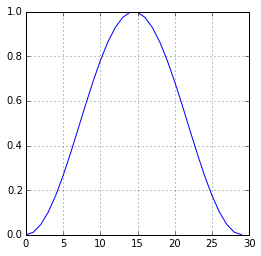

In [298]:
window = np.hanning(30)
plt.figure(figsize=(4,4))
plt.plot(window)
plt.grid(True)

### Before the Filter

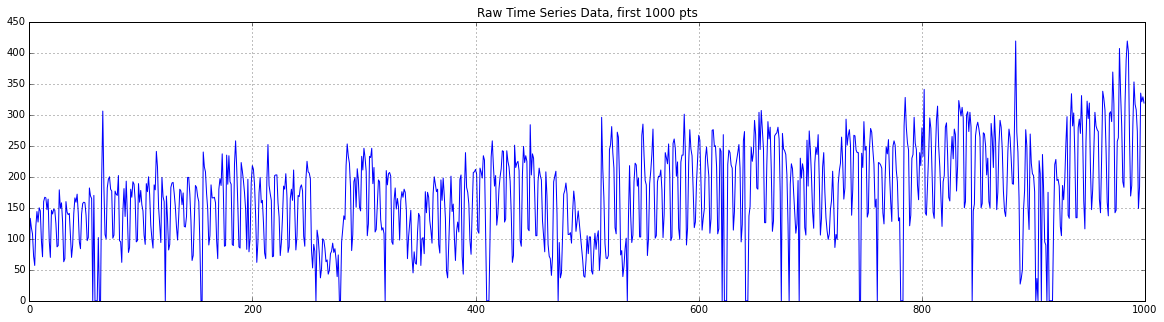

In [299]:
plt.figure()
plt.plot(data[0:1000])
plt.grid(True)
plt.title("Raw Time Series Data, first 1000 pts")

### After the Filter

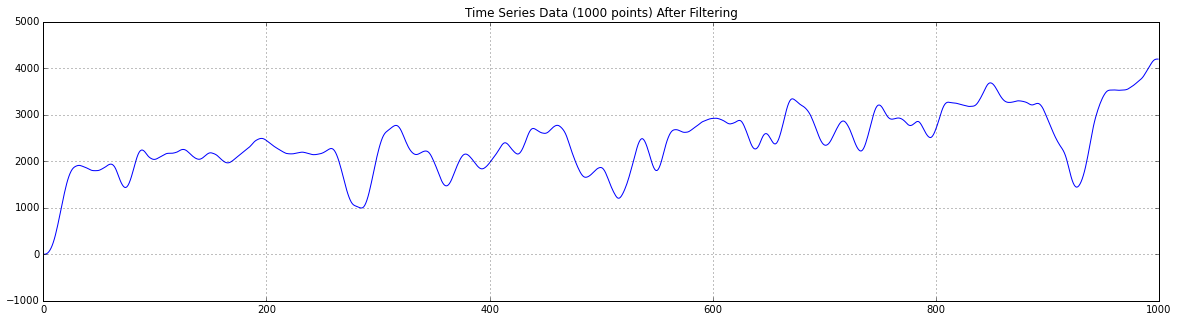

In [300]:
data_filt_30 = sig.fftconvolve(window, data)

plt.plot(data_filt_30[0:1000])
plt.grid(True)
plt.title("Time Series Data (1000 points) After Filtering")

### FFT After Filtering

(0.0, 0.17578125)

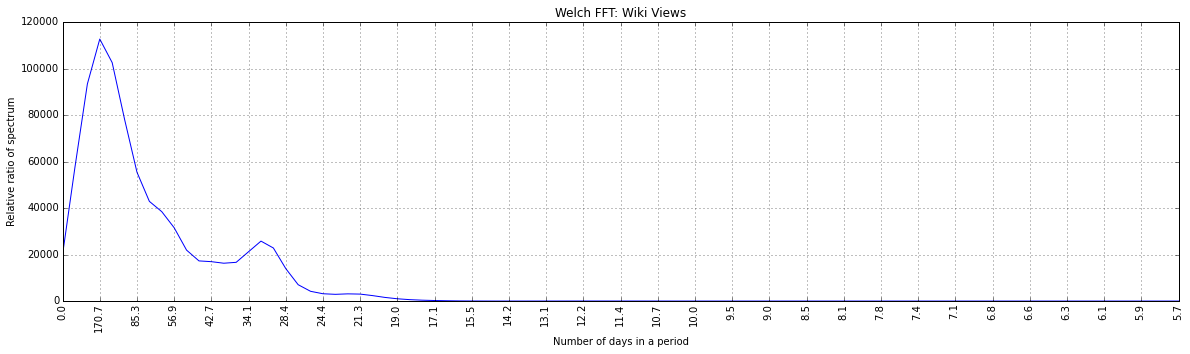

In [301]:
freq, y, frqs = WikiViews.fft(data_filt_30)
plt.xlim(frqs[0], frqs[30])

Although the peak looks bigger, there is no straight forward way to scale the y axis so we need to 
not be too impressed with that. Really, the same two peaks are present as in the original FFT. This plot is simply cleaner. This might seem dumb, but if we where writing a peak-detector, then we'd want a simpler data set.

## Find peaks
<a id='peaks'></a>

### The Savitzky-Golay filer was taken from here:

http://wiki.scipy.org/Cookbook/SavitzkyGolay


In [6]:
from math import factorial

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    # usage and comments removed for brevity see the cookbook link for details
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))

    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")

    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")

    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")

    order_range = range(order+1)
    half_window = (window_size -1) // 2

    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)

    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])

    y = np.concatenate((firstvals, y, lastvals))

    return np.convolve( m[::-1], y, mode='valid')

This function is just an implementation of the first and second derivative tests.

In [7]:
def peak_detection(data):
    der1 = savitzky_golay(data, window_size=3, order=1, deriv=1)
    der2 = savitzky_golay(data, window_size=5, order=2, deriv=2)
    zero_crossings_test = der1[0:-1] * der1[1:]
    peaks = np.where((der2[0:-1] < 0) & (zero_crossings_test < 0))[0]
    
    return peaks

In [304]:
peaks = peak_detection(data_filt_30)

I find the peaks in the time series just to make sure it works.

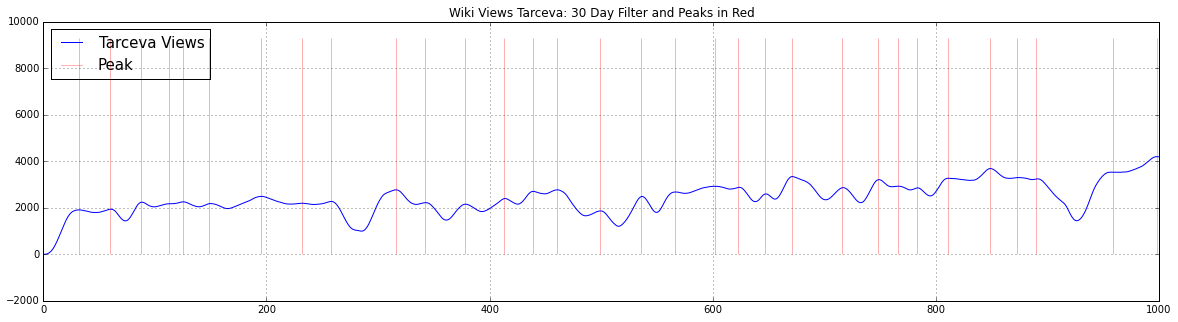

In [305]:
plt.plot(data_filt_30)
plt.grid(True)
plt.xlim(0, 1000)
plt.vlines(peaks, 0, data_filt_30.max(), 'r', alpha=0.3)
plt.title("Wiki Views Tarceva: 30 Day Filter and Peaks in Red")
plt.legend(('Tarceva Views', 'Peak'), loc="upper left", fontsize=15)

Finding peaks is more useful when analyzing an FFT output.

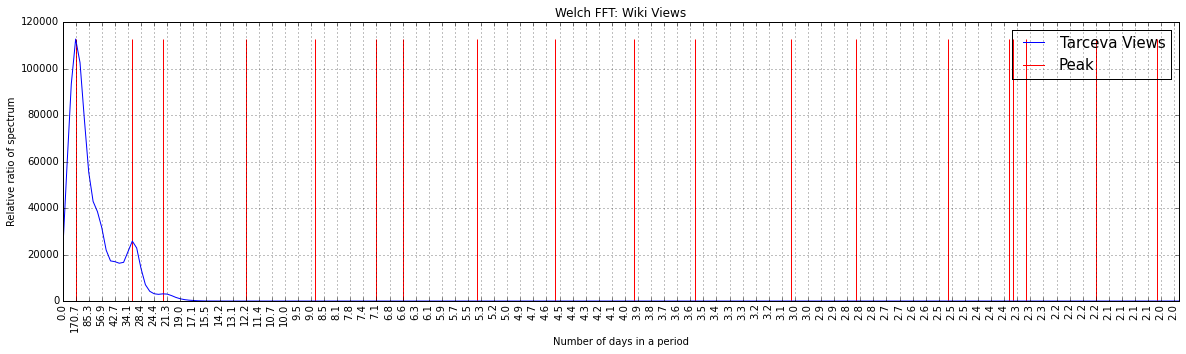

In [306]:
peaks = peak_detection(y)
plt.figure()
freq, y, frqs = WikiViews.fft(data_filt_30)
plt.vlines(freq[peaks], 0, y.max(), 'r')
plt.legend(('Tarceva Views', 'Peak'), fontsize=15)

### Threshold the Peaks
<a id='threshold peaks'></a>

That ripple is most likely just noise from the convolution of delta function during sampling with the actual signal.

The odd harmonics are carried over by the Convolution-Theorm. Using Welch's method helps but does not elleviate the issue.

In [8]:
def thres_peaks(f,y):
    peaks = peak_detection(y)
    max_pk = np.mean(y[peaks]) 
    thres = np.where((y[peaks] >= max_pk))[0]
    return f[peaks[thres]]

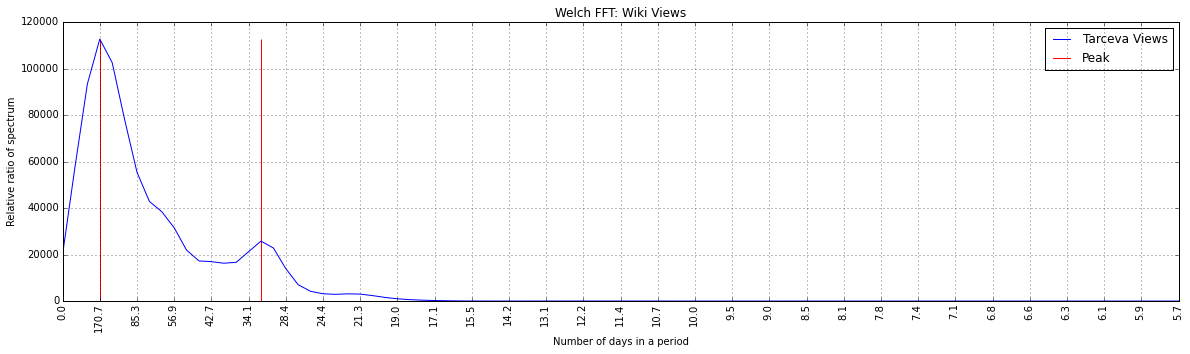

In [308]:
f, y, frqs = WikiViews.fft(data_filt_30)
fp = thres_peaks(f, y)
plt.vlines(fp, 0, y.max(), 'r')
plt.xlim(frqs[0], frqs[30])
plt.legend(('Tarceva Views', 'Peak'))

## Print the periods of interest

In [20]:
def print_fft_periods(fp):
    p = np.round(1/fp, decimals=1)
    pp = " days\n ".join(map(str, p))
    print "The periods of interest are:\n%s days" %pp


In [310]:
print_fft_periods(fp)

The periods of interest are:
170.7 days
 32.0 days


## Get Random Pages
<a id='random'></a>

I'd like to see if there's a general viewing trend with Wikipedia. To do that, I'll need to select pages at random.
Mediawiki has an api for that and there's a button on the Wikipedia homepage. 

_I didn't realize there is a rest api for Wikipedia before I wrote this. I'm leaving it in place since it's a decent regex hack._

In [238]:
import re
obj = re.compile(r'"wgPageName":"(?P<name>\w.*?")') 

def get_random_name():
    random = 'https://en.wikipedia.org/wiki/Special:Random'
    response = urllib2.urlopen(random)
    src_out = response.read()
    response.close()
    
    match = obj.search(src_out)
    #"wgPageName":"foo_bar_bash"
    if match:
        page_name = match.group('name')
        return page_name.replace('"','') # hack to fix above hack
    else:
        return None # handles the case when the page name is not the same as the stats page name

In [241]:
rand_page = get_random_name()
print rand_page
wv = WikiViews(rand_page, start, end)
test_df = wv.loop_over_dates()

Shah_Alam_Circuit


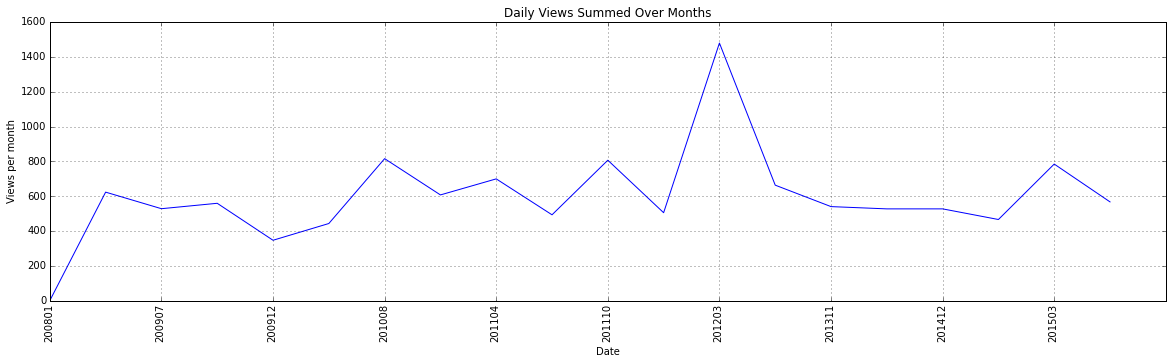

In [242]:
WikiViews.plot_time_series(test_df)

We can see, that not all pages have the same length of history. That will cause problems.
Let's build a collection of random page though and deal with it. In fact I think a linear weight will handle that bias.

The other bias I know for certain, is that not all the Wikipedia page view stat pages are named after the
normal article page. I'll wager that will bias this experiment in some messed up way. 

This is still really a first iteration so I'm not going to try and fix everything.

In [ ]:
def get_random_data(df):
    rand_page = get_random_name()
    print rand_page
    if rand_page is not None:
        wv = WikiViews(rand_page, start, end)
        rand_data = wv.loop_over_dates()
        df[rand_page] = rand_data['daily_views']

    return df

I tried 20 to test things out. 100 or more would be better.

In [214]:
for i in range(20):
    try:
        df = get_random_data(df)
    except KeyboardInterrupt:
        # killing the loop saves the data we have already
        df.to_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_random_data.csv", index=False)
        raise KeyboardInterrupt
        
df.to_csv("/home/daniel/git/Python2.7/DataScience/notebooks/wikipedia_views/wiki_views_random_data.csv", index=False)

In [419]:
df.head()

,egfr,iressa,lung,month,tar,"Evergreen,_Edmonton",Donkey_Punch_(pornographic_film),Bagarmossen_Kärrtorp_BK,Allenwood,Fargo_Moorhead_Metro_Area_Transit,...,Penny_capitalism,Qormi_F.C.,"Lopez,_Quezon",Little_Wilson_and_Big_God,Young_Ace,Toyota_Automobile_Museum,1974_Currie_Cup,Stephanie_Daley,Joyce_Vincent_Wilson,Albert_Julius_Otto_Penzig
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,64,40,1357,200801,47,0,0,0,4,0,...,0,0,16,0,0,3,0,30,43,0
2008-01-02,156,81,2205,200801,133,0,0,0,4,0,...,0,0,13,0,0,1,0,39,30,0
2008-01-03,213,100,2728,200801,118,0,0,0,3,0,...,1,0,22,0,2,3,0,35,48,0
2008-01-04,174,89,2582,200801,108,0,0,0,8,0,...,0,0,31,0,0,8,0,28,35,0
2008-01-05,87,53,1885,200801,72,0,0,0,7,0,...,2,0,12,0,0,4,0,39,39,0


# Averaging Time Series
<a id='ave random'></a>
I'm interested in the periodic viewership in general, per article. So instead of averaging I'm only
normalizing.

I know that our data has holes from failed HTTP requests, and those will show up as NaN's.
Also, some time series are shorter than others. A simple mean will bias the samples b/c of the zeros.

Also, zeros add odd harmonics in the FFT.

For a first iteration, I'm going to normalize by the range of each time series and set all NaN's to zero.

Then I'll interpolate the zeros in the mean to reduce ripple in the FFT.

In [9]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/notebooks/wikipedia_views/wiki_views_random_data.csv")
df.shape

(2860, 27)

In [90]:
arr = df.drop("month", axis=1,inplace=False).as_matrix()
arr = arr.astype(np.float32)
arr.shape

(2860, 26)

In [91]:
range_ = arr.max(axis=0, keepdims=True) - arr.min(axis=0, keepdims=True)
arr /= range_
arr = np.nan_to_num(arr) # handle NaN's created above

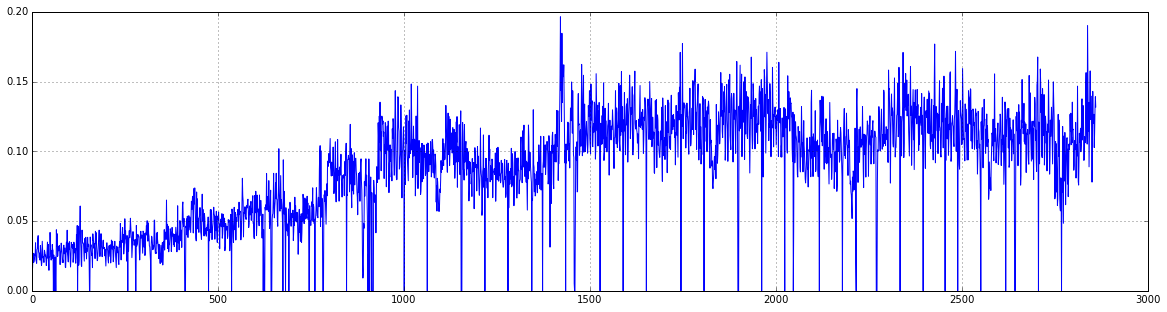

In [92]:
plt.plot(arr.mean(1))
plt.grid()

## Interpolate
<a id='interpolate'></a>
Now we'll use linear interpolation to avoid the arteficial periodicity we'd get from the zeros.

In [93]:
ave_arr_test = arr.mean(axis=1)
z = np.where(ave_arr_test == 0)[0]
num = np.nonzero(ave_arr_test)[0]
ave_arr_test[z] = np.interp(z, num, ave_arr_test[num])

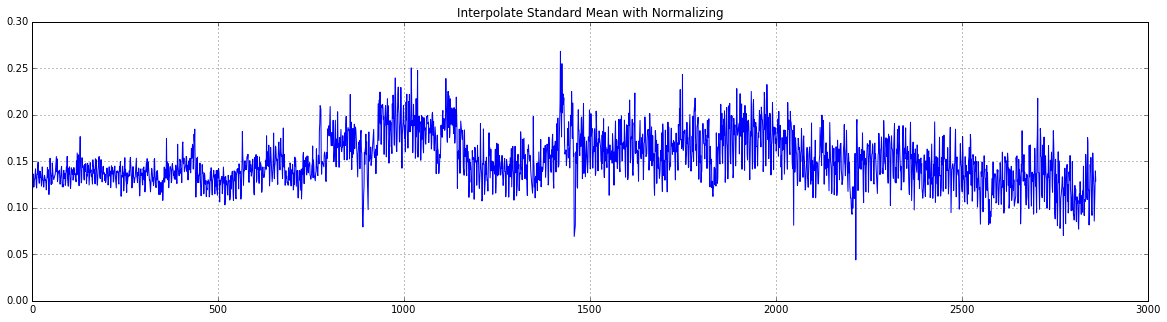

In [99]:
plt.plot(ave_arr)
plt.grid()
plt.title("Interpolate Standard Mean with Normalizing")

## Weighted Average
<a id='weighted ave'></a>

We still would prefer a method that will deal with the different lenghts of the time series.
For that will use a linear weight. The more points, the higher the weight in the average.

We'll need to interpolate the missing points first. This won't affect the long leading zeros **much**. 

In [10]:
def interp(col):
    z = np.where(col == 0)[0]
    num = np.nonzero(col)[0]
    if len(z) < 1 or len(num) < 1:
        return col
    col[z] = np.interp(z, num, col[num])
    return col

def process_for_ave_fft(df):
    arr = df.drop("month", axis=1, inplace=False).as_matrix()
    arr = arr.astype(np.float32)
    range_ = arr.max(axis=0, keepdims=True) - arr.min(axis=0, keepdims=True)
    arr /= range_
    arr = np.nan_to_num(arr) 

    num_non_zeros = map(lambda x:len(np.where(x != 0)[0]), arr.T) # map iterates on rows
    total_points = np.sum(num_non_zeros)

    for i in range(arr.shape[1]):
        arr[:,i] = interp(arr[:,i])
    
    w = num_non_zeros / np.float32(total_points)
    ave_arr = np.average(arr, axis=1, weights=w)
    
    return ave_arr

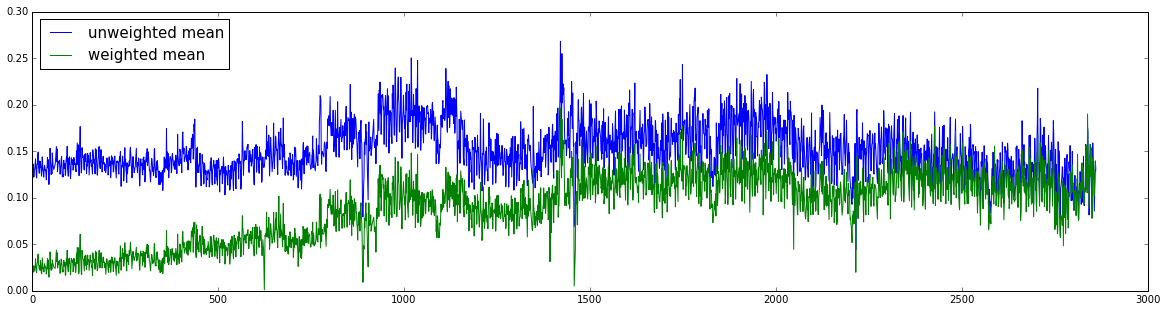

In [101]:
ave_arr = process_for_ave_fft(df)
plt.plot(ave_arr)
plt.plot(ave_arr_test)
plt.legend(("unweighted mean", "weighted mean"), loc="upper left", fontsize=15)

The Welch FFT has an option to linearily detrend the data which is being  used.

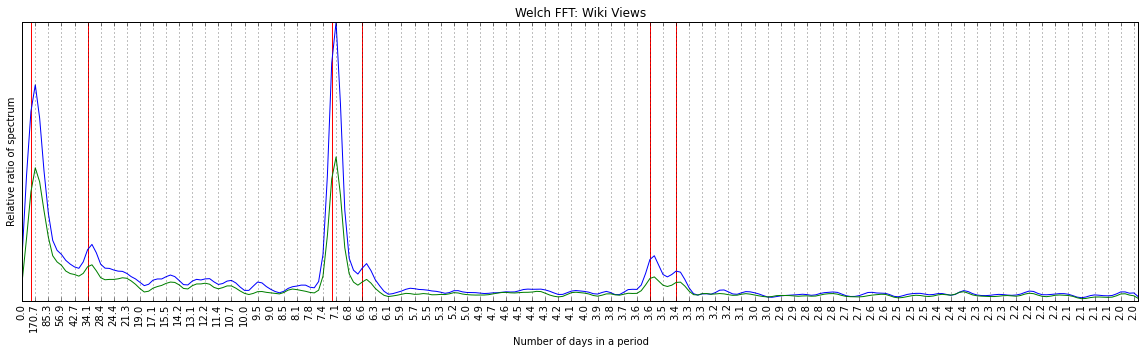

In [102]:
f, y, frqs = WikiViews.fft(ave_arr)
plt.yticks([])
fp = thres_peaks(f, y)
plt.vlines(fp, 0, y.max(), 'r')
f, y, frqs = WikiViews.fft(ave_arr_test)

In [70]:
print_fft_periods(fp)

The periods of interest are:
256.0 days
 34.1 days
 7.2 days
 6.6 days
 3.6 days
 3.4 days


## Mediawiki API 
<a id='api'></a>
We now attemp to grab all page titles in a category

https://en.wikipedia.org/wiki/Special:ApiSandbox#action=query&list=categorymembers&format=json&cmtitle=Category%3A%20Medical%20treatments&cmlimit=100&redirects=

The sandbox is really nice. I came up with a query to get all the article titles for the Medical treatments category with a limit of 100 returns. Since it takes a few hours to pull down the data for that many, I then shuffle the output and select the top 10.

In [252]:
cate_url = "http://en.wikipedia.org//w/api.php?action=query&list=categorymembers&format=json&cmtitle=Category%3A%20Medical%20treatments&cmlimit=100&redirects="
response = urllib2.urlopen(cate_url)
out = response.read()
json_out = json.loads(out)
#json_out['query']['categorymembers']

In [253]:
titles = map(lambda x:x['title'], json_out['query']['categorymembers'])
print titles[0:10]

[u'Abscopal effect', u'Addiction medicine', u'Aguamiel', u'Alglucosidase alfa', u'Alternative uses for placenta', u"Alzheimer's disease research", u'Anthrax immune globulin', u'Antiseptic lavage', u'Apheresis', u'Aquapheresis']


In [254]:
np.random.shuffle(titles)

print titles[0:10]

[u'Interventionism (medicine)', u'Intraosseous infusion', u'Bcr-Abl tyrosine-kinase inhibitor', u'Craterization', u'Dry powder inhaler', u'Dermabrasion', u'Electuary', u'Addiction medicine', u'Immunosuppression', u'Bathroom privileges']


In [123]:
titles = titles[0:10]
title = titles.pop()
tot = len(titles)

start = "1/1/2008"
end = "10/1/2015"

# start with a df filled in for month and date columns
wv = WikiViews(title, start, end )
df_pages = wv.loop_over_dates()
df_pages['date'] = df_pages.index         # required later, when re-loading from CSV
df_pages[title] = df_pages['daily_views'] # reformat cols a little
df_pages.drop(['title','daily_views','project', 'rank'], inplace=True, axis=1)

for i, page in enumerate(titles):
    # on long job it's nice to keep track of how far you've gone
    print "%s: %i of %i" %(page, i, tot)
    try:
        wv = WikiViews(page, start, end )
        data = wv.loop_over_dates()
        df_pages[page] = data['daily_views']
    except KeyboardInterrupt:
        # killing the loop saves the data we have already
        df_pages.to_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_category_data.csv", index=False)
        raise KeyboardInterrupt
        
df_pages.to_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_category_data.csv", index=False)        

EBOO: 0 of 8
Celacade: 1 of 8
Chronotherapy (sleep phase): 2 of 8
Bed rest: 3 of 8
Anthrax immune globulin: 4 of 8
Intraperitoneal injection: 5 of 8
Graded exercise therapy: 6 of 8
Heliox: 7 of 8


I typically re-load the csv file everytime so that I know it works.
I don't want to wait for the data to be acquired when presenting or hacking on this.

In [103]:
df_pages = pd.read_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_category_data.csv")
df_pages.set_index("date", drop=True, inplace=True)

ave = process_for_ave_fft(df_pages)

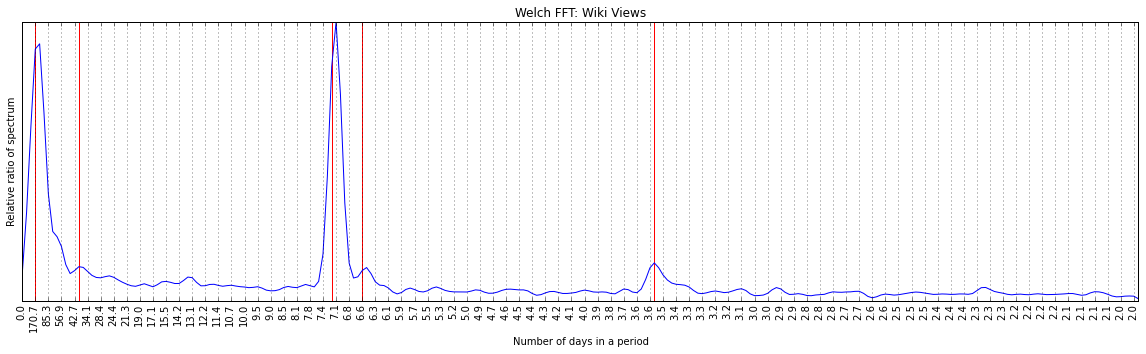

In [104]:
f, y,frqs = WikiViews.fft(ave)
plt.yticks([])
fp = thres_peaks(f, y)
plt.vlines(fp, 0, y.max(), 'r')

In [105]:
print_fft_periods(fp)

The periods of interest are:
170.7 days
 39.4 days
 7.2 days
 6.6 days
 3.5 days


## Detrend The Original Tarceva Data
<a id='detrended_tarceva'></a>

In order to see what is really happening in the Tarceva time series, we need to remove the global trend
of Wikipedia page views. We will use the average of the random data collected above.

In [46]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/notebooks/wikipedia_views/wiki_views_data.csv")
df.set_index("date", drop=True, inplace=True)
df.fillna(value=0, inplace=True)

ave_arr = process_for_ave_fft(df)

from SignalProcessTools import SignalProcessTools
sigtools = SignalProcessTools()

tar = np.squeeze(df['tar'])
tar_detrend = np.squeeze(sigtools.regress_out_confounds(tar, ave_arr))
# the detrending will center the data, therefore we need to transform back to positive numbers
tar_detrend -= tar_detrend.min()

After we detrend, we can't really say what the y axis means anymore. It's not views, because that data is
the original plot. We could say the y axis is the estimated views after removing the global trend.

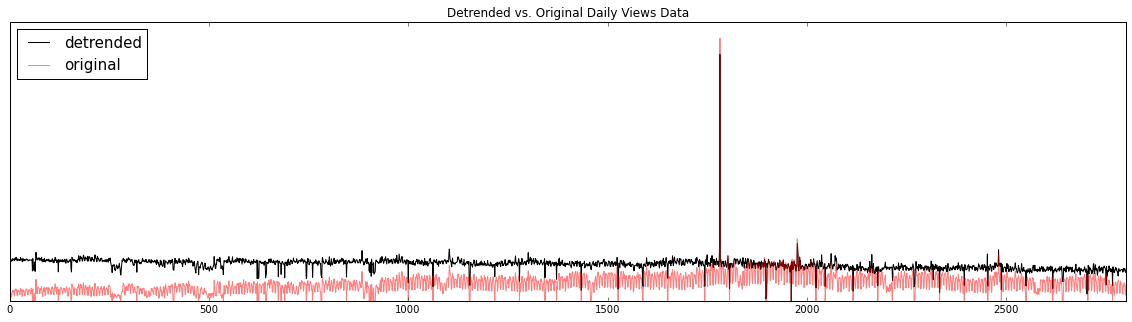

In [54]:
plt.plot(tar_detrend, color='k');
plt.plot(df['tar'], alpha=0.5, color='r')
plt.legend(('detrended', 'original'), loc='upper left', fontsize=15)
plt.xlim(0, 2800)
plt.yticks([])
plt.title("Detrended vs. Original Daily Views Data")

Notice I normed the y axis so that we can think about the curve shapes in relation to each other. 

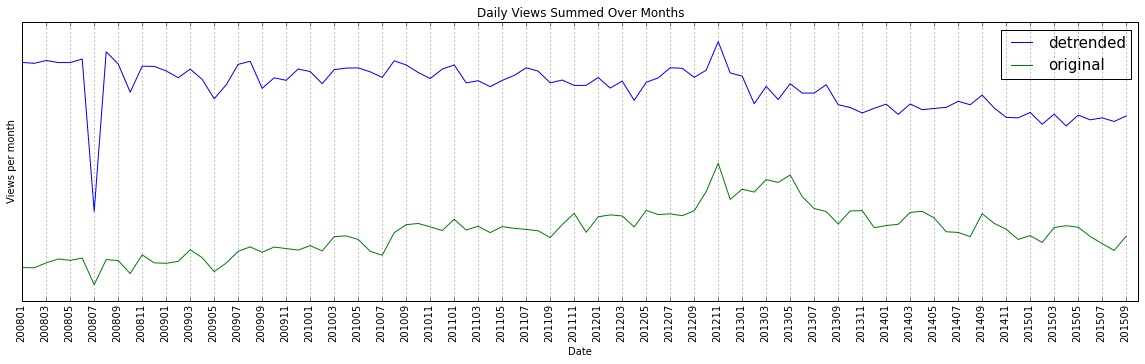

In [56]:
df['detrend_tar'] = tar_detrend
WikiViews.plot_time_series(df[['detrend_tar', 'month']], norm=True)
WikiViews.plot_time_series(df[['tar', 'month']], norm=True)
plt.legend(('detrended', 'original'), loc='upper right', fontsize=15)
plt.yticks([]);

## I couln't get the sink out of my kitchen but there's always the next presentation.